# Atividade Curta 3 - Busca de imagens

#### Aluno: 119891 - João Vitor Silva de Oliveira


In [86]:
%matplotlib inline

import matplotlib.pyplot as plt

import cv2
import numpy as np

from tqdm import trange
import random

# Image Display

In [87]:
def show_image_and_keypoints( image , kps ) :
    cv2.drawKeypoints( image, kps, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS )

    plt.figure(figsize = (10,10))
    plt.imshow(image, aspect='auto')
    plt.axis('off')
    plt.title('Keypoints and descriptors.')
    plt.show()

In [88]:
# AT3: Adjust to show images on the same line
def show_top_images(dataset_path, indices, id_test, ids, labels):
    fig, axes = plt.subplots(1, 11, figsize=(22, 4))  
    
    # Test IMage
    label = (ids[id_test] - 1) // 80
    name = f"{dataset_path}/jpg/{label}/image_{str(ids[id_test]).zfill(4)}.jpg"
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    show_image_label(axes[0], image, labels[id_test], ids[id_test], title="Query")

    # K nearest
    for idx, i in enumerate(indices[0][:10]):  
        label_i = labels[i]
        name = f"{dataset_path}/jpg/{label_i}/image_{str(ids[i]).zfill(4)}.jpg"
        image = cv2.imread(name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        show_image_label(axes[idx + 1], image, label_i, ids[i], title=f"Top {idx+1}")

    plt.tight_layout()
    plt.show()

def show_image_label(ax, image, label, image_id, title=""):
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"{title}\nID {image_id} | Label {label}", fontsize=9)

# Generate descriptors

In [89]:
# AT3: Adjust to accept different algoritms
def detect_and_describe_keypoints ( image, algorithm='orb' ) :
    
    image_gray = cv2.cvtColor( image , cv2.COLOR_BGR2GRAY )
        
    if algorithm == 'sift' :
        keypoint = sift = cv2.SIFT_create()
        kps = keypoint.detect( image_gray, None )    
    
    elif algorithm == 'orb' :
        keypoint = cv2.ORB_create()
        kps = keypoint.detect( image_gray, None )    
    
    # AT3: Generate Random Keypoints
    elif algorithm == 'rand':
        keypoint = cv2.ORB_create() 
        random_keypoints = []
        for _ in range(500):
            x = random.randint(0, image_gray.shape[1] - 1)
            y = random.randint(0, image_gray.shape[0] - 1)
            kp = cv2.KeyPoint(x, y, size=20) 
            random_keypoints.append(kp)
        kps = random_keypoints

    # AT3: Generate GRid Keypoints
    elif algorithm == 'grid':
        keypoint = cv2.ORB_create() 
        grid_keypoints = []
        grid_size = 20
        for y in range(0, image.shape[0], grid_size):
            for x in range(0, image.shape[1], grid_size):
                keypoint = cv2.KeyPoint(x, y, size=20)
                grid_keypoints.append(keypoint)
        kps = grid_keypoints
    
    else :
        print('Error: algorithm not defined')
        return None
    

    # Describing Keypoints
    kps, descs = keypoint.compute( image_gray, kps )
    
    return kps, descs

In [90]:
def create_bovw_descriptors (image, dictionary, algorithm='orb') :
    
    descs = detect_and_describe_keypoints( image, algorithm=algorithm )[1]

    predicted = dictionary.predict(np.array(descs, dtype=np.double))
    
    desc_bovw = np.histogram(predicted, bins=range(0, dictionary.n_clusters+1))[0]
    
    return desc_bovw

In [91]:
from sklearn.cluster import MiniBatchKMeans

def create_dictionary_kmeans ( vocabulary , num_cluster ) :
  
    print( ' -> [I] Dictionary Info:\n', 
        '\nTrain len: ', len(vocabulary),
        '\nDimension: ', len(vocabulary[0]),
        '\nClusters: ', num_cluster 
        )

    dictionary = MiniBatchKMeans( n_clusters=num_cluster, batch_size=1000 )

    print ( 'Learning dictionary by Kmeans...')
    dictionary = dictionary.fit( vocabulary )
    print ( 'Done.')

    return dictionary

# Data

In [92]:
import scipy.io
import tqdm

# AT3: Adjust to accept different algoritms
def create_vocabulary ( dataset_path , algorithm='orb', show_image=False , debug=False ) :

    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['trn1'][0] #  'val1' or 'tst1' 
    
    if algorithm == 'orb' :
        train_descs = np.ndarray( shape=(0,32) , dtype=float )
    elif algorithm == 'sift' :
        train_descs = np.ndarray( shape=(0,128) , dtype=float )

    ## AT3: ADAPT TO RANDOM
    elif algorithm == 'rand':
        train_descs = np.ndarray(shape=(0, 32), dtype=float)

    ## AT3: ADAPT TO GRID
    elif algorithm == 'grid':
        train_descs = np.ndarray(shape=(0, 32), dtype=float)
        
    else :
        print('Error:Algorithm not defined.')
        return None

    for id in tqdm.tqdm(ids, desc='Processing train set') :

        label = (id - 1) // 80
        name = dataset_path + '/jpg/' + str(label) + '/image_' + str(id).zfill(4) + '.jpg'

        image = cv2.imread( name )
        
        if image is None:
            print(f'Reading image Error. Path: {name}')
            return None

        kps, descs = detect_and_describe_keypoints ( image, algorithm=algorithm )
            
        train_descs = np.concatenate((train_descs, descs), axis=0)
        
        if show_image :
            show_image_and_keypoints(image, kps)

        if debug :
            print( name )
            print( 'Number of keypoints: ', len(kps) )
            print( 'Number of images: ', len(ids) )
            print( 'Descriptor size: ', len(descs[0]) )
            print( type(descs[0]) )
      
    print( ' -> [I] Image Loader Info:\n', 
      '\nTrain len: ', len(train_descs),
      '\nNumber of images: ', len(ids),
      '\nDescriptor size: ', len(descs[0])      
      )
    
    return train_descs

# Dictionary

In [93]:
def represent_dataset( dataset_path, dictionary , algorithm='orb' ) :

    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['tst1'][0] #  'tst1' or 'trn1' or 'val1' 
    
    space = []
    labels = []
    
    for id in tqdm.tqdm(ids, desc='Processing test set') :

        label = (id - 1) // 80
        name = dataset_path + '/jpg/' + str(label) + '/image_' + str(id).zfill(4) + '.jpg'

        image = cv2.imread( name )
        
        if image is None:
            print(f'Reading image Error. Path: {name}')
            return None

        desc_bovw = create_bovw_descriptors(image, dictionary, algorithm=algorithm)

        space.append(desc_bovw)
        labels.append(label)
        
    print( ' -> [I] Space Describing Info:\n', 
        '\nNumber of images: ', len(space), 
        '\nNumber of labels: ', len(labels),
        '\nDimension: ', len(space[0])
        )

    return space , labels 

In [94]:
from sklearn.neighbors import NearestNeighbors

def run_test ( space , labels , dictionary , dataset_path, algorithm='orb', top=10 ) :
    knn = NearestNeighbors(n_neighbors=top+1).fit(space)
    
    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['tst1'][0] #  'tst1' or 'trn1' or 'val1'
    
    accuracy_t = 0
    
    for id_test in tqdm.tqdm(ids, desc='running the test phase') :
        
        label = (id_test - 1) // 80
        name = dataset_path + '/jpg/' + str(label) + '/image_' + str(id_test).zfill(4) + '.jpg'

        image = cv2.imread( name )
        
        desc_bovw = create_bovw_descriptors(image, dictionary, algorithm=algorithm)

        indices = knn.kneighbors(desc_bovw.reshape(1, -1))[1]

        labels_top = [ labels[i] for i in indices[0] ]

        accuracy = sum( np.equal(labels_top, label) )
        accuracy =( (accuracy-1)/(top) ) * 100
        accuracy_t = accuracy_t + accuracy
        
    print(f'Average accuracy in the test set: {accuracy_t/len(ids):5.2f}%')
    

# Experimental evaluation

In [95]:
def retrieve_single_image ( space , labels , dictionary , dataset_path, algorithm='orb', top=10 ) :
    knn = NearestNeighbors(n_neighbors=top+1).fit(space)
    
    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['tst1'][0] #  'trn1' or 'val1'
    
    id_test = random.randrange( len(ids) )
        
    label = (ids[id_test] - 1) // 80
    name = dataset_path + '/jpg/' + str(label) + '/image_' + str(ids[id_test]).zfill(4) + '.jpg'
    
    image = cv2.imread( name )
    
    if image is None:
        print(f'Reading image Error. Path: {name}')
        return None

    desc_bovw = create_bovw_descriptors(image, dictionary, algorithm=algorithm)
    
    distances, indices = knn.kneighbors(desc_bovw.reshape(1, -1))
    
    show_top_images(dataset_path, indices, id_test, ids, labels)
    
    labels_top = [ int(labels[i]) for i in indices[0] ]
    
    accuracy = sum( np.equal( label , labels_top ) )
    accuracy =( (accuracy-1)/(top) ) * 100 
    
    print(f'Accuracy for image id {ids[id_test]}: {accuracy:5.2f}%')
    
    print(name)    
    print(f'Image: {ids[id_test]} with label {labels[id_test]}')    
    print(f'Closest image: {ids[indices[0][0]]} with distance {distances[0][0]} and label {labels[indices[0][0]]}')
    print('Distances: ',distances)
    print('Indices: ',indices[0])
    print('Labels: ',labels_top)

# Execution

## SIFT

In [96]:
dataset_path = './flowers_classes'
algorithm = 'sift' # Chose the detector/descriptor: 'orb' or 'sift'
num_cluster = 100 # SET HERE THE BoVW DESCRIPTOR SIZE 

vocabulary = create_vocabulary( dataset_path, algorithm=algorithm ) 

dictionary = create_dictionary_kmeans( vocabulary , num_cluster=num_cluster )

space, labels = represent_dataset ( dataset_path , dictionary, algorithm=algorithm )

Processing train set: 100%|██████████| 680/680 [01:57<00:00,  5.77it/s]


 -> [I] Image Loader Info:
 
Train len:  1233814 
Number of images:  680 
Descriptor size:  128
 -> [I] Dictionary Info:
 
Train len:  1233814 
Dimension:  128 
Clusters:  100
Learning dictionary by Kmeans...
Done.


Processing test set: 100%|██████████| 340/340 [00:26<00:00, 12.92it/s]

 -> [I] Space Describing Info:
 
Number of images:  340 
Number of labels:  340 
Dimension:  100


In [97]:
run_test( space, labels, dictionary, dataset_path, algorithm=algorithm )

running the test phase: 100%|██████████| 340/340 [00:26<00:00, 12.77it/s]

Average accuracy in the test set: 20.50%


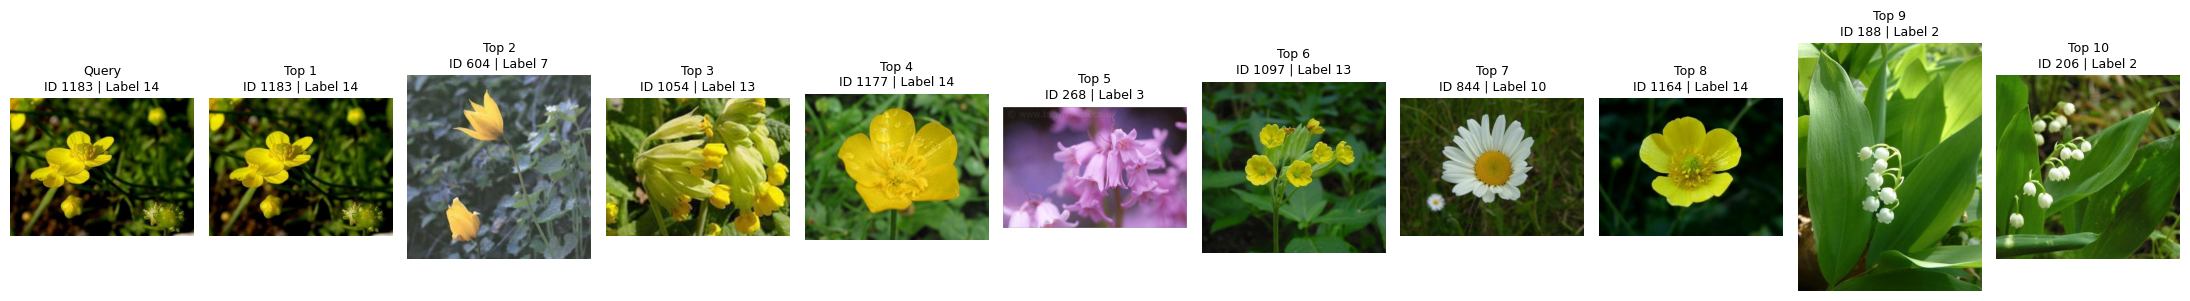

Accuracy for image id 1183: 20.00%
./flowers_classes/jpg/14/image_1183.jpg
Image: 1183 with label 14
Closest image: 1183 with distance 0.0 and label 14
Distances:  [[ 0.         40.73082371 44.23799272 45.74931693 48.03123983 48.0416486
  50.71488933 51.53639491 53.26349594 53.53503526 53.85164807]]
Indices:  [295 150 263 299  61 279 210 290  41  54 323]
Labels:  [14, 7, 13, 14, 3, 13, 10, 14, 2, 2, 16]


In [98]:
retrieve_single_image( space, labels, dictionary, dataset_path , algorithm=algorithm)

## ORB

In [105]:
dataset_path = './flowers_classes'
algorithm = 'orb' # Chose the detector/descriptor: 'orb' or 'sift'
num_cluster = 100 # SET HERE THE BoVW DESCRIPTOR SIZE 

vocabulary = create_vocabulary( dataset_path, algorithm=algorithm ) 

dictionary = create_dictionary_kmeans( vocabulary , num_cluster=num_cluster )

space, labels = represent_dataset ( dataset_path , dictionary, algorithm=algorithm )

Processing train set: 100%|██████████| 680/680 [00:09<00:00, 74.18it/s] 


 -> [I] Image Loader Info:
 
Train len:  333473 
Number of images:  680 
Descriptor size:  32
 -> [I] Dictionary Info:
 
Train len:  333473 
Dimension:  32 
Clusters:  100
Learning dictionary by Kmeans...
Done.


Processing test set: 100%|██████████| 340/340 [00:02<00:00, 136.60it/s]

 -> [I] Space Describing Info:
 
Number of images:  340 
Number of labels:  340 
Dimension:  100


In [106]:
run_test( space, labels, dictionary, dataset_path, algorithm=algorithm )

running the test phase: 100%|██████████| 340/340 [00:02<00:00, 123.27it/s]

Average accuracy in the test set: 17.91%


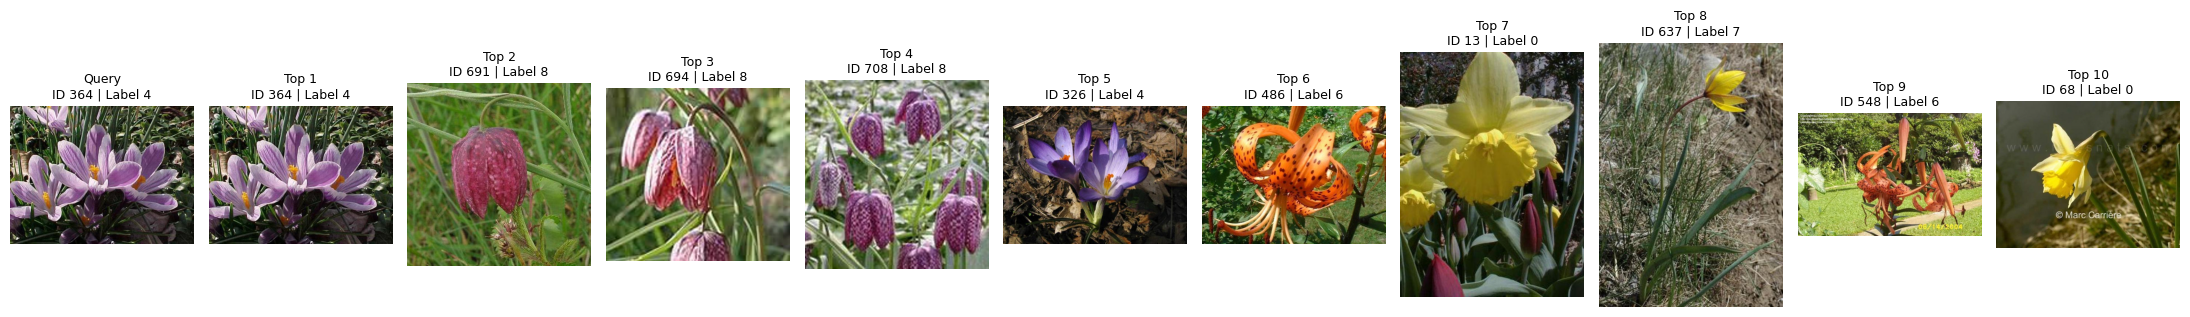

Accuracy for image id 364: 10.00%
./flowers_classes/jpg/4/image_0364.jpg
Image: 364 with label 4
Closest image: 364 with distance 0.0 and label 4
Distances:  [[ 0.         32.28002478 33.346664   35.0142828  35.27038418 35.35533906
  36.60601044 36.63331817 36.93237063 37.04051835 37.09447398]]
Indices:  [ 90 172 173 171  84 124   8 156 131  11  35]
Labels:  [4, 8, 8, 8, 4, 6, 0, 7, 6, 0, 1]


In [107]:
retrieve_single_image( space, labels, dictionary, dataset_path , algorithm=algorithm)

## RANDOM

In [99]:
dataset_path = './flowers_classes'
algorithm = 'rand' 
num_cluster = 100 

vocabulary = create_vocabulary( dataset_path, algorithm=algorithm ) 

dictionary = create_dictionary_kmeans( vocabulary , num_cluster=num_cluster )

space, labels = represent_dataset ( dataset_path , dictionary, algorithm=algorithm )


Processing train set: 100%|██████████| 680/680 [00:05<00:00, 132.26it/s]


 -> [I] Image Loader Info:
 
Train len:  268189 
Number of images:  680 
Descriptor size:  32
 -> [I] Dictionary Info:
 
Train len:  268189 
Dimension:  32 
Clusters:  100
Learning dictionary by Kmeans...
Done.


Processing test set: 100%|██████████| 340/340 [00:01<00:00, 324.10it/s]

 -> [I] Space Describing Info:
 
Number of images:  340 
Number of labels:  340 
Dimension:  100


In [100]:
run_test( space, labels, dictionary, dataset_path, algorithm=algorithm )

running the test phase: 100%|██████████| 340/340 [00:01<00:00, 264.28it/s]

Average accuracy in the test set:  6.47%


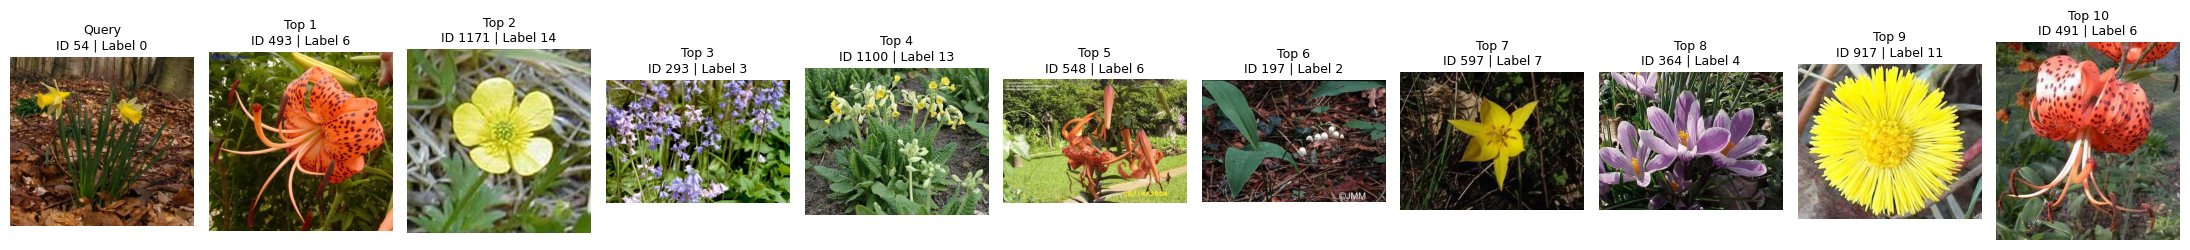

Accuracy for image id 54: -10.00%
./flowers_classes/jpg/0/image_0054.jpg
Image: 54 with label 0
Closest image: 493 with distance 26.70205984563738 and label 6
Distances:  [[26.70205985 26.77685568 27.16615541 27.20294102 27.34958866 27.58622845
  27.58622845 27.83882181 27.92848009 27.98213716 28.0713377 ]]
Indices:  [128 292  78 277 131  46 146  90 226 122 276]
Labels:  [6, 14, 3, 13, 6, 2, 7, 4, 11, 6, 13]


In [101]:
retrieve_single_image( space, labels, dictionary, dataset_path , algorithm=algorithm)

## GRID

In [102]:
dataset_path = './flowers_classes'
algorithm = 'grid' 
num_cluster = 100 

vocabulary = create_vocabulary( dataset_path, algorithm=algorithm ) 

dictionary = create_dictionary_kmeans( vocabulary , num_cluster=num_cluster )

space, labels = represent_dataset ( dataset_path , dictionary, algorithm=algorithm )

Processing train set: 100%|██████████| 680/680 [00:05<00:00, 131.19it/s]


 -> [I] Image Loader Info:
 
Train len:  268212 
Number of images:  680 
Descriptor size:  32
 -> [I] Dictionary Info:
 
Train len:  268212 
Dimension:  32 
Clusters:  100
Learning dictionary by Kmeans...
Done.


Processing test set: 100%|██████████| 340/340 [00:01<00:00, 327.26it/s]

 -> [I] Space Describing Info:
 
Number of images:  340 
Number of labels:  340 
Dimension:  100


In [103]:
run_test( space, labels, dictionary, dataset_path, algorithm=algorithm )

running the test phase: 100%|██████████| 340/340 [00:01<00:00, 262.66it/s]

Average accuracy in the test set:  6.97%


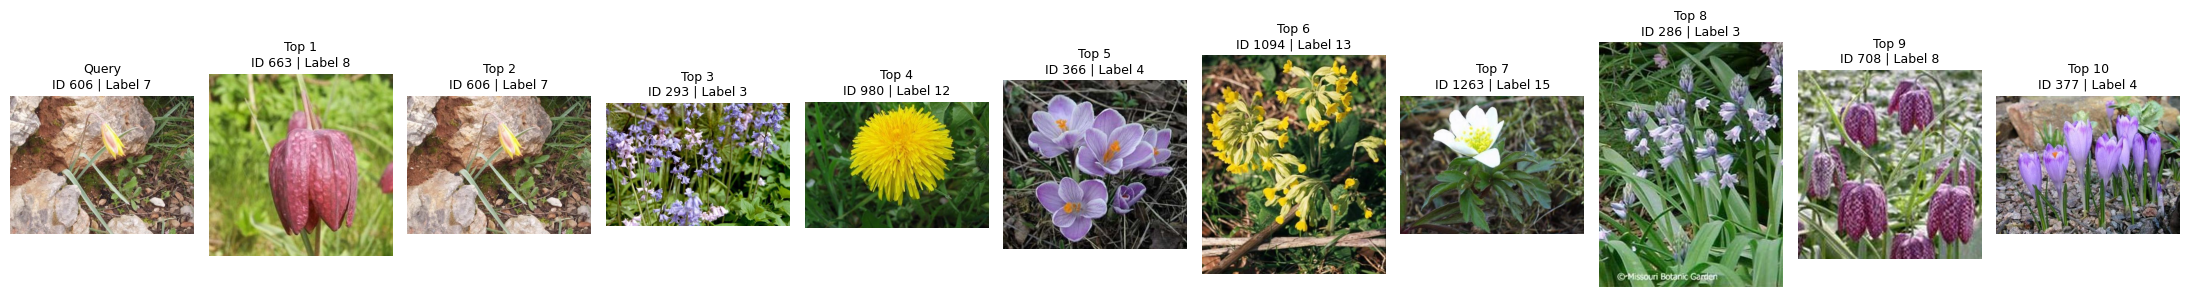

Accuracy for image id 606:  0.00%
./flowers_classes/jpg/7/image_0606.jpg
Image: 606 with label 7
Closest image: 663 with distance 25.592967784139454 and label 8
Distances:  [[25.59296778 26.2488095  26.43860813 26.66458325 26.68332813 26.75817632
  26.88865932 26.88865932 26.92582404 27.47726333 27.51363298]]
Indices:  [165 154  78 247  94 273 315  74 171  99 238]
Labels:  [8, 7, 3, 12, 4, 13, 15, 3, 8, 4, 11]


In [104]:
retrieve_single_image( space, labels, dictionary, dataset_path , algorithm=algorithm)

# Results and Discussions

After calculating the accuracy, the following results were obtained:

- **SIFT**: 20,50%
- **ORB**: 17,91%
- **Random Keypoints**: 6,47%
- **Grid**: 6,97%

The results show that methods based on intelligently detected features, such as SIFT (20,50%) and ORB (17,91%), achieve higher accuracies because they extract representative keypoints that aid in differentiating images. In contrast, random (6,47%) and grid (6,97%) keypoint methods perform significantly worse, as they distribute keypoints without considering the structure or important characteristics of the image, resulting in a less effective representation. These results highlight the importance of specialized techniques for extracting relevant features in the context of image classification.